نیماجمالی ۹۶۱۰۵۶۶۱
علیرضا دقیق ۹۶۱۰۵۷۲۳



In [ ]:

import random
import numpy as np
from math import inf
from scipy.stats import expon, bernoulli
import matplotlib.pyplot as plt
from copy import deepcopy
from matplotlib import colors as mcolors
import time as timer1
from math import fabs
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)


In [ ]:
class Reception:
  def __init__(self, rate):
    self.rate = rate
    self.p1=[]
    self.p2=[]
    self.p3=[]
    self.p4=[]
    self.p0=[]
    self.p1_len = 0
    self.p2_len = 0
    self.p3_len = 0
    self.p4_len = 0
    self.p0_len = 0
    self.service_end = inf

In [ ]:
class FoodType:
  def __init__(self, free_clerks):
    self.free_clerks = free_clerks
    self.p0=[]
    self.p1=[]
    self.p2=[]
    self.p3=[]
    self.p4=[]
    self.p0_len = 0
    self.p1_len = 0
    self.p2_len = 0
    self.p4_len = 0
    self.p3_len = 0
      

In [ ]:

class Clerk:
    def __init__(self, rate, food_type, n):
        self.food_type = food_type
        self.service_end = inf
        self.service_time = expon.rvs(scale=1/rate, size=n).tolist()
        self.count = 0
    


In [ ]:
import random
class Restaurant:
  def __init__(self, n, types_number, arrival_rate, boredom_rate, reception_rate, types, clerks):
    self.n = n
    self.types_number = types_number
    self.arrival_rate = arrival_rate
    self.boredom_rate = boredom_rate
    self.reception_rate = reception_rate
    self.df = dict()
    self.reception = Reception(reception_rate)
    self.types = types
    self.clerks = clerks
    self.initialize()
    self.in_reception = None

  def create_priority(self, n):
    ret = [0 for _ in range(n)]
    for i in range(n):
      rand = random.random()
      if 0.5 <= rand < 0.7:
        ret[i] = 1
      elif 0.7 <= rand < 0.85:
        ret[i] = 2
      elif 0.85 <= rand < 0.95:
        ret[i] = 3
      elif rand >= 0.95:
        ret[i] = 4
    return np.array(ret)


  def create_category(self, n, size):
    ret = [random.randint(0, n - 1) for _ in range(size)]
    return np.array(ret)

  def initialize(self):
    self.df['inter_arrival_time'] = expon.rvs(scale=1 / self.arrival_rate, size=self.n)
    self.df['arrival_time'] = np.append(np.cumsum(self.df['inter_arrival_time']), inf)

    self.df['reception_time'] = expon.rvs(scale=1 / self.reception.rate, size=self.n)
    self.df['in_system_time'] = np.zeros(self.n)
    self.df['in_system_people'] = [[0 ,0 ,0 ,0 ,0 ,0]]  #x[i] = [time_i, num_pos_people_in_timei, num_neg_people_in_timei]
    self.df['boredom_time_with_exp'] = expon.rvs(scale=self.boredom_rate, size=self.n + 1)
    self.df['boredom_time'] = self.df['arrival_time'] + self.df['boredom_time_with_exp'] # expon.rvs(scale=self.boredom_rate, size=self.n + 1)
    self.df['got_bored'] = [0 for _ in range(self.n)] 
    self.df['waiting_time'] = np.zeros(self.n)
    self.df['priority'] = self.create_priority(self.n)
    self.df['reception_queue_length'] = [[[0, 0]], [[0, 0]] , [[0, 0]], [[0, 0]], [[0, 0]]]  # x[0] -> pos_queue  x[1] -> neg_queue
    self.df['types_queue_length'] = [[[[0, 0]], [[0, 0]], [[0, 0]], [[0, 0]], [[0, 0]]] for _ in
                                      self.types]  # x[i] -> room_i,  x[i][0] -> pos_queue : [time, length]
    self.df['category'] = self.create_category(self.types_number, self.n)

    self.df['service_time'] = [None for _ in range(self.n)]



  def find_next_event(self, count):
        clerk_num = np.argmin([clerk.service_end for clerk in self.clerks])
        current_time = self.clerks[clerk_num].service_end
        event = 'clerk'

        bored_customer = -1
        resign_time = inf
        in_line = self.reception.p0 + self.reception.p1 + self.reception.p2 + self.reception.p3 + self.reception.p4
        in_line_len = self.reception.p0_len + self.reception.p1_len + self.reception.p2_len + self.reception.p3_len + self.reception.p4_len

        for type_ in self.types:
            in_line += type_.p0 + type_.p1 + type_.p2 + type_.p3 + type_.p4
            in_line_len += type_.p0_len + type_.p1_len + type_.p2_len + type_.p3_len + type_.p4_len
        if in_line_len != 0:

            for i in in_line:
                if self.df['boredom_time'][i] < resign_time:
                    bored_customer = i
                    resign_time = self.df['boredom_time'][i]
            # print(self.df['boredom_time'][bored_customer], 'boredom')
            # print(resign_time, 'resign time')
            # print(self.reception.service_end, 'service end')
            # print(current_time, 'current')
            # print(self.df['arrival_time'][count], 'arrival time')
            # print("############################################")

            if resign_time < current_time:
                current_time = resign_time
                event = 'boredom'

        if self.reception.service_end < current_time:
            current_time = self.reception.service_end
            event = 'reception'

        if self.df['arrival_time'][count] < current_time:
            current_time = self.df['arrival_time'][count]
            event = 'arrival'
        # print(f'event is {event}, {current_time}, {clerk_num}, {bored_customer}')
        return current_time, event, clerk_num, bored_customer 


  def manage_arrival(self, customer_num, current_time):
    if self.reception.service_end == inf:  # first patient in the reception list
      self.reception.service_end = self.df['reception_time'][customer_num] + current_time


      self.in_reception = customer_num
      if self.df['priority'][customer_num] == 0:
        self.df['in_system_people'].append([current_time, self.df['in_system_people'][-1][1] + 1,
                                          self.df['in_system_people'][-1][2],
                                          self.df['in_system_people'][-1][3],
                                          self.df['in_system_people'][-1][4],
                                          self.df['in_system_people'][-1][5]])


      elif self.df['priority'][customer_num] == 1 :
        self.df['in_system_people'].append([current_time, self.df['in_system_people'][-1][1],
                                          self.df['in_system_people'][-1][2]+1,
                                          self.df['in_system_people'][-1][3],
                                          self.df['in_system_people'][-1][4],
                                          self.df['in_system_people'][-1][5]])
      elif self.df['priority'][customer_num] == 2 :
        self.df['in_system_people'].append([current_time, self.df['in_system_people'][-1][1],
                                          self.df['in_system_people'][-1][2],
                                          self.df['in_system_people'][-1][3] + 1,
                                          self.df['in_system_people'][-1][4],
                                          self.df['in_system_people'][-1][5]])

      elif self.df['priority'][customer_num] == 3 :
        self.df['in_system_people'].append([current_time, self.df['in_system_people'][-1][1],
                                          self.df['in_system_people'][-1][2],
                                          self.df['in_system_people'][-1][3] ,
                                          self.df['in_system_people'][-1][4] + 1,
                                          self.df['in_system_people'][-1][5]])

      elif self.df['priority'][customer_num] == 4 :
        self.df['in_system_people'].append([current_time, self.df['in_system_people'][-1][1],
                                          self.df['in_system_people'][-1][2],
                                          self.df['in_system_people'][-1][3] ,
                                          self.df['in_system_people'][-1][4],
                                          self.df['in_system_people'][-1][5]+1])





    elif self.df['priority'][customer_num] == 0:
      self.reception.p0.append(customer_num)
      self.reception.p0_len += 1
      self.df['in_system_people'].append([current_time, self.df['in_system_people'][-1][1]+1,
                                          self.df['in_system_people'][-1][2],
                                          self.df['in_system_people'][-1][3] ,
                                          self.df['in_system_people'][-1][4],
                                          self.df['in_system_people'][-1][5]])
    elif self.df['priority'][customer_num] == 1:
      self.reception.p1.append(customer_num)
      self.reception.p1_len += 1
      self.df['in_system_people'].append([current_time, self.df['in_system_people'][-1][1],
                                          self.df['in_system_people'][-1][2]+1,
                                          self.df['in_system_people'][-1][3] ,
                                          self.df['in_system_people'][-1][4],
                                          self.df['in_system_people'][-1][5]])
      
    elif self.df['priority'][customer_num] == 2:
      self.reception.p2.append(customer_num)
      self.reception.p2_len += 1
      self.df['in_system_people'].append([current_time, self.df['in_system_people'][-1][1],
                                          self.df['in_system_people'][-1][2],
                                          self.df['in_system_people'][-1][3]+1 ,
                                          self.df['in_system_people'][-1][4],
                                          self.df['in_system_people'][-1][5]])
    elif self.df['priority'][customer_num] == 3:
      self.reception.p3.append(customer_num)
      self.reception.p3_len += 1
      self.df['in_system_people'].append([current_time, self.df['in_system_people'][-1][1],
                                          self.df['in_system_people'][-1][2],
                                          self.df['in_system_people'][-1][3] ,
                                          self.df['in_system_people'][-1][4]+1,
                                          self.df['in_system_people'][-1][5]])
    elif self.df['priority'][customer_num] == 4:
      self.reception.p4.append(customer_num)
      self.reception.p4_len += 1
      self.df['in_system_people'].append([current_time, self.df['in_system_people'][-1][1],
                                          self.df['in_system_people'][-1][2],
                                          self.df['in_system_people'][-1][3] ,
                                          self.df['in_system_people'][-1][4],
                                          self.df['in_system_people'][-1][5]+1])
      


  
  def manage_reception(self, current_time):
        cat = self.df['category'][self.in_reception]
        f_type = self.types[cat]
        if self.df['priority'][self.in_reception] == 0:

            f_type.p0.append(self.in_reception)
            f_type.p0_len += 1
            self.df['types_queue_length'][cat][0].append([current_time, f_type.p0_len])

        elif self.df['priority'][self.in_reception] == 1:

            f_type.p1.append(self.in_reception)
            f_type.p1_len += 1
            self.df['types_queue_length'][cat][1].append([current_time, f_type.p1_len])

        elif self.df['priority'][self.in_reception] == 2:

            f_type.p2.append(self.in_reception)
            f_type.p2_len += 1
            self.df['types_queue_length'][cat][2].append([current_time, f_type.p2_len])

        elif self.df['priority'][self.in_reception] == 3:

            f_type.p3.append(self.in_reception)
            f_type.p3_len += 1
            self.df['types_queue_length'][cat][3].append([current_time, f_type.p3_len])

        elif self.df['priority'][self.in_reception] == 4:

            f_type.p4.append(self.in_reception)
            f_type.p4_len += 1
            self.df['types_queue_length'][cat][4].append([current_time, f_type.p4_len])




        if f_type.free_clerks:
           
            clerk_num = f_type.free_clerks.pop(0)

            self.manage_clerk(current_time, clerk_num)

        customer_num = None
        if self.reception.p4_len != 0:  # self.reception.pos_queue:

            customer_num = self.reception.p4.pop(0)

            self.reception.p4_len -= 1
            self.df['reception_queue_length'][4].append([current_time, self.reception.p4_len])

        elif self.reception.p3_len != 0:  # self.reception.pos_queue:

            customer_num = self.reception.p3.pop(0)

            self.reception.p3_len -= 1
            self.df['reception_queue_length'][3].append([current_time, self.reception.p3_len])
        elif self.reception.p2_len != 0:  # self.reception.pos_queue:

            customer_num = self.reception.p2.pop(0)

            self.reception.p2_len -= 1
            self.df['reception_queue_length'][2].append([current_time, self.reception.p2_len])
        elif self.reception.p1_len != 0:  # self.reception.pos_queue:
            customer_num = self.reception.p1.pop(0)

            self.reception.p1_len -= 1
            self.df['reception_queue_length'][1].append([current_time, self.reception.p1_len])
        elif self.reception.p0_len != 0:  # self.reception.pos_queue

            customer_num = self.reception.p0.pop(0)

            self.reception.p0_len -= 1
            self.df['reception_queue_length'][0].append([current_time, self.reception.p0_len])
        
        if customer_num is None:
            self.reception.service_end = inf
            return

        self.in_reception = customer_num
        self.reception.service_end = self.df['reception_time'][self.in_reception] + current_time

  def manage_clerk(self, current_time, clerk_num):
        clerk = self.clerks[clerk_num]
        f_type = self.types[clerk.food_type]

        customer_num = None
        if f_type.p4_len != 0:  # room.pos_queue:

            customer_num = f_type.p4.pop(0)

            f_type.p4_len -= 1
            self.df['in_system_people'].append([current_time, self.df['in_system_people'][-1][1]
                                                , self.df['in_system_people'][-1][2]
                                                , self.df['in_system_people'][-1][3]
                                                , self.df['in_system_people'][-1][4]
                                                , self.df['in_system_people'][-1][5] - 1])
            self.df['types_queue_length'][clerk.food_type][4].append([current_time, f_type.p4_len])

        elif f_type.p3_len != 0:  # room.pos_queue:

            customer_num = f_type.p3.pop(0)

            f_type.p3_len -= 1
            self.df['in_system_people'].append([current_time, self.df['in_system_people'][-1][1]
                                                , self.df['in_system_people'][-1][2]
                                                , self.df['in_system_people'][-1][3]
                                                , self.df['in_system_people'][-1][4] - 1
                                                , self.df['in_system_people'][-1][5]])
            self.df['types_queue_length'][clerk.food_type][3].append([current_time, f_type.p3_len])
        elif f_type.p2_len != 0:  # room.pos_queue:

            customer_num = f_type.p2.pop(0)

            f_type.p2_len -= 1
            self.df['in_system_people'].append([current_time, self.df['in_system_people'][-1][1]
                                                , self.df['in_system_people'][-1][2]
                                                , self.df['in_system_people'][-1][3] - 1
                                                , self.df['in_system_people'][-1][4]
                                                , self.df['in_system_people'][-1][5]])
            self.df['types_queue_length'][clerk.food_type][2].append([current_time, f_type.p2_len])
        elif f_type.p1_len != 0:  # room.pos_queue:

            customer_num = f_type.p1.pop(0)

            f_type.p1_len -= 1
            self.df['in_system_people'].append([current_time, self.df['in_system_people'][-1][1]
                                                , self.df['in_system_people'][-1][2] - 1
                                                , self.df['in_system_people'][-1][3]
                                                , self.df['in_system_people'][-1][4]
                                                , self.df['in_system_people'][-1][5]])
            self.df['types_queue_length'][clerk.food_type][1].append([current_time, f_type.p1_len])
        elif f_type.p0_len != 0:  # room.pos_queue:

            customer_num = f_type.p0.pop(0)

            f_type.p0_len -= 1
            self.df['in_system_people'].append([current_time, self.df['in_system_people'][-1][1] - 1
                                                , self.df['in_system_people'][-1][2]
                                                , self.df['in_system_people'][-1][3]
                                                , self.df['in_system_people'][-1][4]
                                                , self.df['in_system_people'][-1][5] ])
            self.df['types_queue_length'][clerk.food_type][0].append([current_time, f_type.p0_len])
        

        if customer_num is None:
            f_type.free_clerks.append(clerk_num)
            clerk.service_end = inf

            return

        s = clerk.service_time[clerk.count]
        clerk.count += 1

        self.df['service_time'][customer_num] = s

        self.df['in_system_time'][customer_num] = current_time + s - self.df['arrival_time'][customer_num]
        self.df['waiting_time'][customer_num] = self.df['in_system_time'][customer_num] - self.df['reception_time'][
            customer_num] - s

        clerk.service_end = current_time + s


  def manage_boredom(self, current_time, bored_customer):  # deletes the bored patient from whatever the queue he's in

        self.df['got_bored'][bored_customer] = 1
        self.df['boredom_time'][bored_customer] = inf
        self.df['in_system_time'][bored_customer] = current_time - self.df['arrival_time'][bored_customer]

        if bored_customer in self.reception.p0:
            # print(self.reception.pos_queue)
            # bored_patient_index = np.where(np.array(self.reception.pos_queue) == bored_patient)[0][0]
            # self.reception.pos_queue =  np.delete(self.reception.pos_queue, bored_patient_index)
            self.reception.p0.remove(bored_customer)
            self.reception.p0_len -= 1
            self.df['in_system_people'].append([current_time, self.df['in_system_people'][-1][1] - 1,
                                               self.df['in_system_people'][-1][2],
                                               self.df['in_system_people'][-1][3],
                                               self.df['in_system_people'][-1][4],
                                               self.df['in_system_people'][-1][5]],
                                               )
            self.df['reception_queue_length'][0].append([current_time, self.reception.p0_len])
            self.df['waiting_time'][bored_customer] = self.df['in_system_time'][bored_customer]
        elif bored_customer in self.reception.p1:
            # bored_patient_index = np.where(self.reception.neg_queue== bored_patient)
            # self.reception.neg_queue = np.delete(self.reception.neg_queue, bored_patient_index)
            self.reception.p1.remove(bored_customer)
            self.reception.p1_len -= 1
            self.df['reception_queue_length'][1].append([current_time, self.reception.p1_len])
            self.df['waiting_time'][bored_customer] = self.df['in_system_time'][bored_customer]
            self.df['in_system_people'].append([current_time, self.df['in_system_people'][-1][1],
                                               self.df['in_system_people'][-1][2] - 1,
                                               self.df['in_system_people'][-1][3],
                                               self.df['in_system_people'][-1][4],
                                               self.df['in_system_people'][-1][5]],
                                               )
        elif bored_customer in self.reception.p2:
            # bored_patient_index = np.where(self.reception.neg_queue== bored_patient)
            # self.reception.neg_queue = np.delete(self.reception.neg_queue, bored_patient_index)
            self.reception.p2.remove(bored_customer)
            self.reception.p2_len -= 1
            self.df['reception_queue_length'][2].append([current_time, self.reception.p2_len])
            self.df['waiting_time'][bored_customer] = self.df['in_system_time'][bored_customer]
            self.df['in_system_people'].append([current_time, self.df['in_system_people'][-1][1],
                                               self.df['in_system_people'][-1][2],
                                               self.df['in_system_people'][-1][3] - 1,
                                               self.df['in_system_people'][-1][4],
                                               self.df['in_system_people'][-1][5]],
                                               )
        elif bored_customer in self.reception.p3:
            # bored_patient_index = np.where(self.reception.neg_queue== bored_patient)
            # self.reception.neg_queue = np.delete(self.reception.neg_queue, bored_patient_index)
            self.reception.p3.remove(bored_customer)
            self.reception.p3_len -= 1
            self.df['reception_queue_length'][3].append([current_time, self.reception.p3_len])
            self.df['waiting_time'][bored_customer] = self.df['in_system_time'][bored_customer]
            self.df['in_system_people'].append([current_time, self.df['in_system_people'][-1][1],
                                               self.df['in_system_people'][-1][2],
                                               self.df['in_system_people'][-1][3],
                                               self.df['in_system_people'][-1][4] - 1,
                                               self.df['in_system_people'][-1][5]],
                                               )
        elif bored_customer in self.reception.p4:
            # bored_patient_index = np.where(self.reception.neg_queue== bored_patient)
            # self.reception.neg_queue = np.delete(self.reception.neg_queue, bored_patient_index)
            self.reception.p4.remove(bored_customer)
            self.reception.p4_len -= 1
            self.df['reception_queue_length'][4].append([current_time, self.reception.p4_len])
            self.df['waiting_time'][bored_customer] = self.df['in_system_time'][bored_customer]
            self.df['in_system_people'].append([current_time, self.df['in_system_people'][-1][1],
                                               self.df['in_system_people'][-1][2],
                                               self.df['in_system_people'][-1][3],
                                               self.df['in_system_people'][-1][4],
                                               self.df['in_system_people'][-1][5] - 1],
                                               )
        else:
            for (type_id, food_type) in enumerate(self.types):
                if bored_customer in food_type.p0:
                    # bored_patient_index = np.where(room.pos_queue == bored_patient)
                    # room.pos_queue = np.delete(room.pos_queue, bored_patient_index)
                    food_type.p0.remove(bored_customer)
                    food_type.p0_len -= 1
                    self.df['types_queue_length'][type_id][0].append([current_time, food_type.p0_len])
                    self.df['waiting_time'][bored_customer] = self.df['in_system_time'][bored_customer] - \
                                                             self.df['reception_time'][bored_customer]

                    self.df['in_system_people'].append([current_time, self.df['in_system_people'][-1][1] - 1,
                                               self.df['in_system_people'][-1][2],
                                               self.df['in_system_people'][-1][3],
                                               self.df['in_system_people'][-1][4],
                                               self.df['in_system_people'][-1][5]],
                                               )
                elif bored_customer in food_type.p1:
                    # bored_patient_index = np.where(room.pos_queue == bored_patient)
                    # room.pos_queue = np.delete(room.pos_queue, bored_patient_index)
                    food_type.p1.remove(bored_customer)
                    food_type.p1_len -= 1
                    self.df['types_queue_length'][type_id][1].append([current_time, food_type.p1_len])
                    self.df['waiting_time'][bored_customer] = self.df['in_system_time'][bored_customer] - \
                                                             self.df['reception_time'][bored_customer]

                    self.df['in_system_people'].append([current_time, self.df['in_system_people'][-1][1],
                                               self.df['in_system_people'][-1][2] - 1,
                                               self.df['in_system_people'][-1][3],
                                               self.df['in_system_people'][-1][4],
                                               self.df['in_system_people'][-1][5]],
                                               )
                elif bored_customer in food_type.p2:
                    # bored_patient_index = np.where(room.pos_queue == bored_patient)
                    # room.pos_queue = np.delete(room.pos_queue, bored_patient_index)
                    food_type.p2.remove(bored_customer)
                    food_type.p2_len -= 1
                    self.df['types_queue_length'][type_id][2].append([current_time, food_type.p2_len])
                    self.df['waiting_time'][bored_customer] = self.df['in_system_time'][bored_customer] - \
                                                             self.df['reception_time'][bored_customer]

                    self.df['in_system_people'].append([current_time, self.df['in_system_people'][-1][1],
                                               self.df['in_system_people'][-1][2],
                                               self.df['in_system_people'][-1][3] - 1,
                                               self.df['in_system_people'][-1][4],
                                               self.df['in_system_people'][-1][5]],
                                               )
                elif bored_customer in food_type.p3:
                    # bored_patient_index = np.where(room.pos_queue == bored_patient)
                    # room.pos_queue = np.delete(room.pos_queue, bored_patient_index)
                    food_type.p3.remove(bored_customer)
                    food_type.p3_len -= 1
                    self.df['types_queue_length'][type_id][3].append([current_time, food_type.p3_len])
                    self.df['waiting_time'][bored_customer] = self.df['in_system_time'][bored_customer] - \
                                                             self.df['reception_time'][bored_customer]

                    self.df['in_system_people'].append([current_time, self.df['in_system_people'][-1][1],
                                               self.df['in_system_people'][-1][2],
                                               self.df['in_system_people'][-1][3],
                                               self.df['in_system_people'][-1][4] - 1,
                                               self.df['in_system_people'][-1][5]],
                                               )
                elif bored_customer in food_type.p4:
                    # bored_patient_index = np.where(room.pos_queue == bored_patient)
                    # room.pos_queue = np.delete(room.pos_queue, bored_patient_index)
                    food_type.p4.remove(bored_customer)
                    food_type.p4_len -= 1
                    self.df['types_queue_length'][type_id][4].append([current_time, food_type.p4_len])
                    self.df['waiting_time'][bored_customer] = self.df['in_system_time'][bored_customer] - \
                                                             self.df['reception_time'][bored_customer]

                    self.df['in_system_people'].append([current_time, self.df['in_system_people'][-1][1],
                                               self.df['in_system_people'][-1][2],
                                               self.df['in_system_people'][-1][3],
                                               self.df['in_system_people'][-1][4],
                                               self.df['in_system_people'][-1][5] - 1],
                                               )

  def simulate(self):
      print('simulating:')
      self.df['start_time'] = timer1.time()
      count = 0
      time = 0
      while time != inf:
          # print('count =', count)
          # print(self.reception.pos_queue, self.reception.neg_queue)
          # print(self.rooms[0].pos_queue, self.rooms[0].neg_queue)
          # print(self.rooms[1].pos_queue, self.rooms[1].neg_queue)
          time, event, clerk_num, bored_customer = self.find_next_event(count)
          current_time = time
          if event == 'arrival':
              # print('a')
              self.manage_arrival(count, current_time)
              count += 1
              if count % 1000000 == 0:
                  print(count)
          elif event == 'reception':
              # print('r')
              self.manage_reception(current_time)
          elif event == 'clerk':
              # print('d')
              self.manage_clerk(current_time, clerk_num)
          elif event == 'boredom':
              # print('b')
              self.manage_boredom(current_time, bored_customer)
      self.df['end_time'] = timer1.time()
      return self.df


In [ ]:
type_count, arrival_rate, boredom_mean, reception_rate = list(map(float, input().split()))
type_count = int(type_count)

n = 5000000


clerks = []
types = []
initial_rates = []
x = 0
for i in range(type_count):
  rates = (list(map(float, input().split())))
  initial_rates.append(rates)
  new_clerks = [Clerk(rate, i, n) for rate in rates]
  types.append(FoodType(list(range(x, x + len(new_clerks)))))
  x += len(new_clerks)
  clerks += new_clerks

restaurant = Restaurant(n, type_count, arrival_rate, boredom_mean, reception_rate, types, clerks)
df = restaurant.simulate()
print('time:', timer1.strftime('%H:%M:%S', timer1.gmtime(df['end_time'] - df['start_time'])))
del clerks
del types
del restaurant



2 5 30 8
12 10
8 13 6
simulating:
1000000
2000000
3000000
4000000
5000000
time: 00:05:41


In [ ]:

# 1 average time spent on syst1em
in_system_time = df['in_system_time']
priority = df['priority']

mean_in_system_time = np.mean(in_system_time)
mean_in_system_time_p0 = np.sum(df['in_system_time'] * np.array(list(map(lambda x: 1 if x == 0 else 0, priority)))) / np.shape(np.where(priority == 0))[1]
mean_in_system_time_p1 = np.sum(df['in_system_time'] * np.array(list(map(lambda x: 1 if x == 1 else 0, priority)))) / np.shape(np.where(priority == 1))[1]
mean_in_system_time_p2 = np.sum(df['in_system_time'] * np.array(list(map(lambda x: 1 if x == 2 else 0, priority)))) / np.shape(np.where(priority == 2))[1]
mean_in_system_time_p3 = np.sum(df['in_system_time'] * np.array(list(map(lambda x: 1 if x == 3 else 0, priority))))/ np.shape(np.where(priority == 3))[1]
mean_in_system_time_p4 = np.sum(df['in_system_time'] * np.array(list(map(lambda x: 1 if x == 4 else 0, priority)))) / np.shape(np.where(priority == 4))[1]



print('average time in system: {:.3f}\n'
      'average time of zero priority in system: {:.3f}\n'
      'average time of one priority in system: {:.3f}\n'
      'average time of two priority in system: {:.3f}\n'
       'average time of three priority in system: {:.3f}\n'
        'average time of four priority in system: {:.3f}\n'.format(mean_in_system_time, mean_in_system_time_p0, mean_in_system_time_p1,mean_in_system_time_p2,mean_in_system_time_p3,mean_in_system_time_p4))


average time in system: 0.428
average time of zero priority in system: 0.514
average time of one priority in system: 0.367
average time of two priority in system: 0.336
average time of three priority in system: 0.318
average time of four priority in system: 0.311



In [ ]:
# 2 average waiting time
waiting_time = df['waiting_time']
mean_waiting_time = np.mean(waiting_time)
mean_waiting_time_p0 = np.sum(waiting_time * np.array(list(map(lambda x: 1 if x == 0 else 0, priority)))) / np.shape(np.where(priority == 0))[1]
mean_waiting_time_p1 = np.sum(waiting_time * np.array(list(map(lambda x: 1 if x == 1 else 0, priority)))) / np.shape(np.where(priority == 1))[1]
mean_waiting_time_p2 = np.sum(waiting_time * np.array(list(map(lambda x: 1 if x == 2 else 0, priority)))) / np.shape(np.where(priority == 2))[1]
mean_waiting_time_p3 = np.sum(waiting_time * np.array(list(map(lambda x: 1 if x == 3 else 0, priority)))) / np.shape(np.where(priority == 3))[1]
mean_waiting_time_p4 = np.sum(waiting_time * np.array(list(map(lambda x: 1 if x == 4 else 0, priority)))) / np.shape(np.where(priority == 4))[1]

print('average waiting time in system: {:.3f}\n'
      'average waiting time of zero priority in system: {:.3f}\n'
      'average waiting of one priority in system: {:.3f}\n'
      'average waiting time of two priority in system: {:.3f}\n'
      'average waiting time of three priority in system: {:.3f}\n'
      'average waiting time of four priority in system: {:.3f}\n'.format(mean_waiting_time, mean_waiting_time_p0,
                                                                          mean_waiting_time_p1,mean_waiting_time_p2,mean_waiting_time_p3
                                                                         ,mean_waiting_time_p4))



average waiting time in system: 0.199
average waiting time of zero priority in system: 0.285
average waiting of one priority in system: 0.137
average waiting time of two priority in system: 0.105
average waiting time of three priority in system: 0.088
average waiting time of four priority in system: 0.080



In [ ]:
# 3 bored people
bored_people = np.sum(df['got_bored'])
print('number of patients who got bored and left the system: {:d}'.format(bored_people))



number of patients who got bored and left the system: 33582


In [ ]:

def get_mean_length(queue):
    '''

    :param queue: queue[i] -> [time_i, length_i]
    :return:
    '''
    average = 0
    time = queue[0][0]
    length = queue[0][1]
    for i  in range(len(queue)):
        if i > 0:
            average += (queue[i][0] - time)* length
            time = queue[i][0]
            length = queue[i][1]

    return average / time

In [ ]:

# 4 Queue lengths
reception_p0_queue, reception_p1_queue,reception_p2_queue,reception_p3_queue,reception_p4_queue = df['reception_queue_length']
reception_p0_queue_mean_length = get_mean_length(reception_p0_queue)
reception_p1_queue_mean_length = get_mean_length(reception_p1_queue)
reception_p2_queue_mean_length = get_mean_length(reception_p2_queue)
reception_p3_queue_mean_length = get_mean_length(reception_p3_queue)
reception_p4_queue_mean_length = get_mean_length(reception_p4_queue)



print('p0 reception average queue length is {:.3f}\n'
      'p1 reception average queue length is {:.3f}\n'
      'p2 reception average queue length is {:.3f}\n'
      'p3 reception average queue length is {:.3f}\n'
      'p4 reception average queue length is {:.3f}\n'.format(reception_p0_queue_mean_length,
                                                            reception_p1_queue_mean_length,
                                                             reception_p2_queue_mean_length,
                                                             reception_p3_queue_mean_length,
                                                             reception_p4_queue_mean_length))

type_queues = df['types_queue_length']
for i in range(type_count):
  p0, p1, p2, p3, p4 = type_queues[i]
  p0 = get_mean_length(p0)
  p1 = get_mean_length(p1)
  p2 = get_mean_length(p2)
  p3 = get_mean_length(p3)
  p4 = get_mean_length(p4)
  print('type {:d} p0 queue length is {:.3f}, and p1 type queue length is {:.3f}, and p2 type queue length is {:.3f}, and p3 type queue length is {:.3f}, and p4 type queue length is {:.3f}'.format(i,p0, p1, p2, p3,p4))


p0 reception average queue length is 0.319
p1 reception average queue length is 0.021
p2 reception average queue length is 0.008
p3 reception average queue length is 0.003
p4 reception average queue length is 0.001

type 0 p0 queue length is 0.002, and p1 type queue length is 0.000, and p2 type queue length is 0.000, and p3 type queue length is 0.000, and p4 type queue length is 0.000
type 1 p0 queue length is 0.000, and p1 type queue length is 0.000, and p2 type queue length is 0.000, and p3 type queue length is 0.000, and p4 type queue length is 0.000


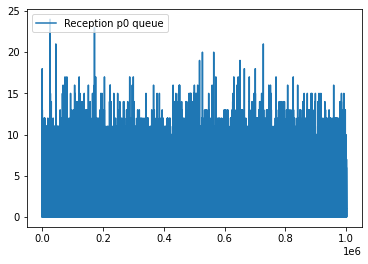

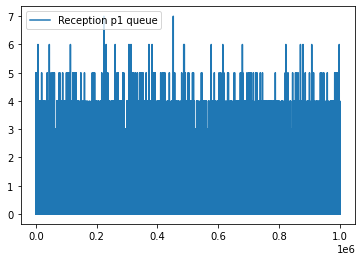

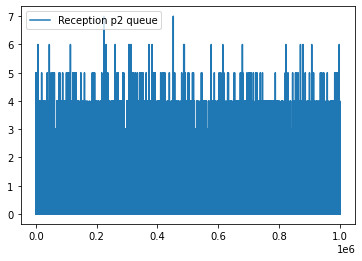

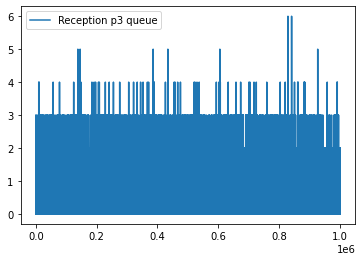

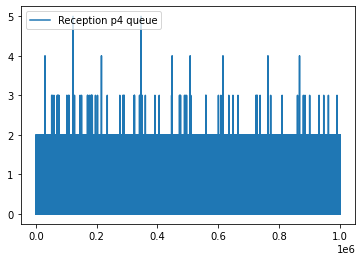

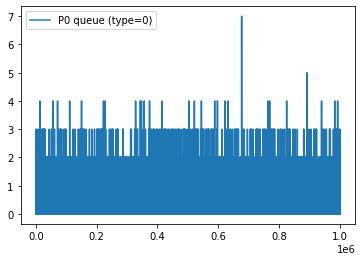

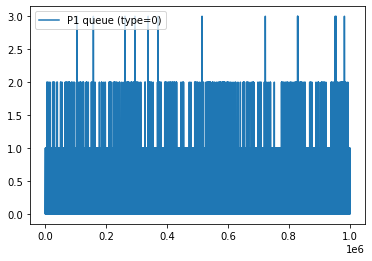

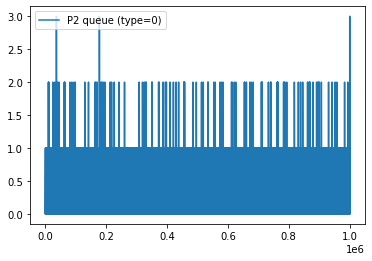

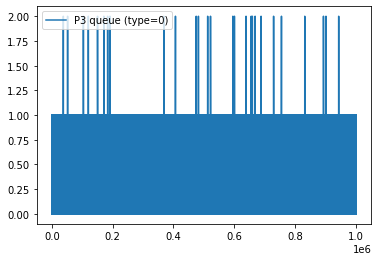

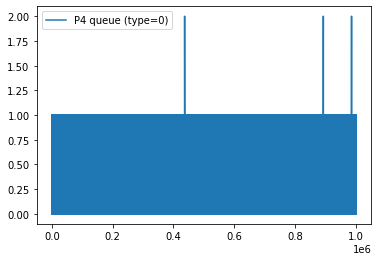

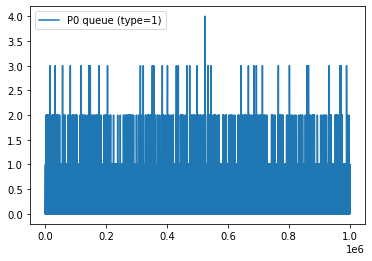

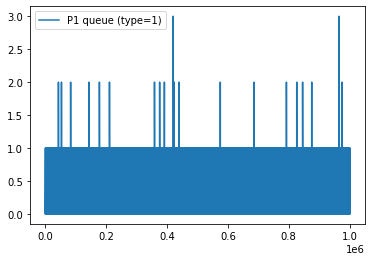

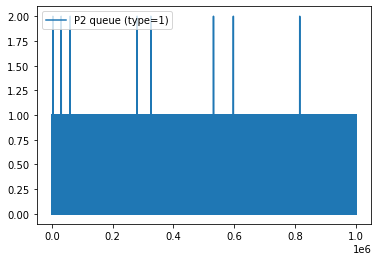

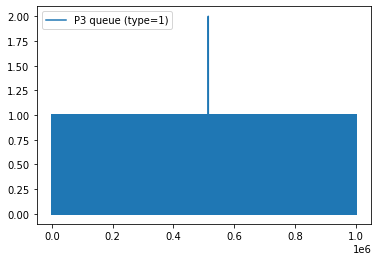

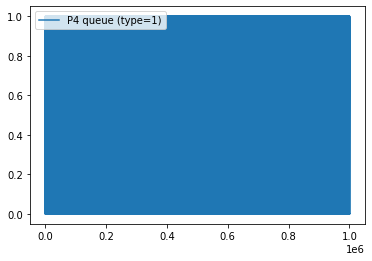

In [ ]:
# 6 Queue lengths plot
reception_p0_queue, reception_p2_queue, reception_p3_queue, reception_p4_queue, reception_p5_queue = df['reception_queue_length']

plt.figure()
x, y = zip(*reception_p0_queue)
plt.step(x, y, label="Reception p0 queue")
plt.legend(loc='upper left')
# plt.savefig("plots/5/Reception_p0_queue.png")

plt.figure()
x, y = zip(*reception_p1_queue)
plt.step(x, y, label="Reception p1 queue")
plt.legend(loc='upper left')
# plt.savefig("plots/5/Reception_p1_queue.png")

plt.figure()
x, y = zip(*reception_p2_queue)
plt.step(x, y, label="Reception p2 queue")
plt.legend(loc='upper left')
# plt.savefig("plots/5/Reception_p2_queue.png")

plt.figure()
x, y = zip(*reception_p3_queue)
plt.step(x, y, label="Reception p3 queue")
plt.legend(loc='upper left')
# plt.savefig("plots/5/Reception_p3_queue.png")

plt.figure()
x, y = zip(*reception_p4_queue)
plt.step(x, y, label="Reception p4 queue")
plt.legend(loc='upper left')
# plt.savefig("plots/5/Reception_p4_queue.png")

for i in range(len(df['types_queue_length'])):
  p0_queue, p1_queue, p2_queue, p3_queue, p4_queue = df['types_queue_length'][i]
  plt.figure()
  x, y = zip(*p0_queue)
  plt.step(x, y, label="P0 queue (type={})".format(i))
  plt.legend(loc='upper left')
  # plt.savefig("plots/6/Type_{}_p0_queue.png".format(i))

  plt.figure()
  x, y = zip(*p1_queue)
  plt.step(x, y, label="P1 queue (type={})".format(i))
  plt.legend(loc='upper left')
  # plt.savefig("plots/6/Type_{}_p1_queue.png".format(i))

  plt.figure()
  x, y = zip(*p2_queue)
  plt.step(x, y, label="P2 queue (type={})".format(i))
  plt.legend(loc='upper left')
  # plt.savefig("plots/6/Type_{}_p2_queue.png".format(i))

  plt.figure()
  x, y = zip(*p3_queue)
  plt.step(x, y, label="P3 queue (type={})".format(i))
  plt.legend(loc='upper left')
  # plt.savefig("plots/6/Type_{}_p3_queue.png".format(i))

  plt.figure()
  x, y = zip(*p4_queue)
  plt.step(x, y, label="P4 queue (type={})".format(i))
  plt.legend(loc='upper left')
  # plt.savefig("plots/6/Type_{}_p4_queue.png".format(i))
  plt.show()

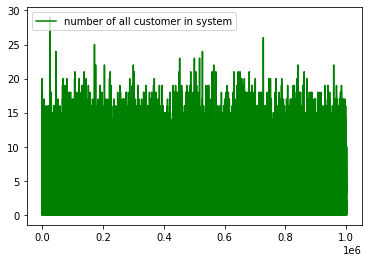

No handles with labels found to put in legend.


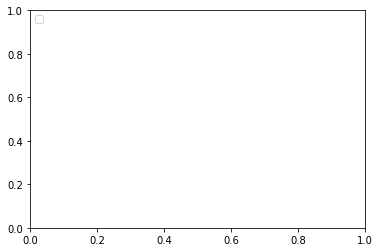

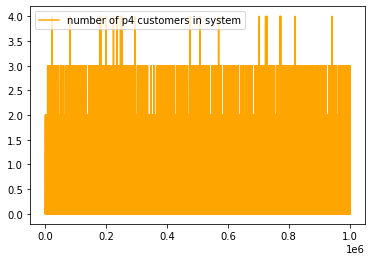

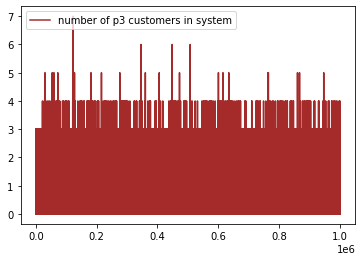

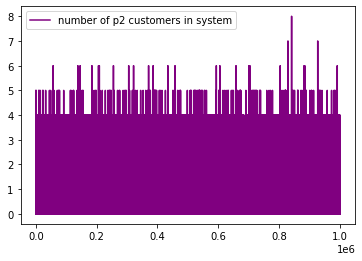

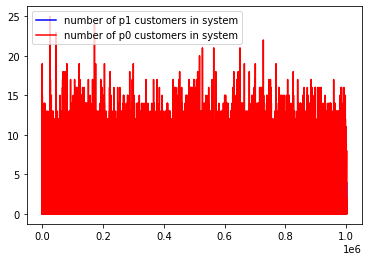

In [ ]:
# 7 customer in system frequency plot
# in_system, all_time = get_in_system_count(arrival_time[:-1], leave_time, test)
in_system = df['in_system_people']

x = [row[0] for row in in_system]
y_1 = [row[1] for row in in_system]

y_2 = [row[2] for row in in_system]

y_3 = [row[3] for row in in_system]

y_4 = [row[4] for row in in_system]

y_5 = [row[5] for row in in_system]

y_6 = [row[1] + row[2] + row[3] + row[4] + row[5] for row in in_system]

plt.figure()
c6 = colors['green']
plt.plot(x, y_6, label="number of all customer in system", c=c6)
plt.legend(loc='upper left')
plt.show()
c5 = colors['orange']
plt.legend(loc='upper left')
plt.show()
plt.plot(x, y_5, label="number of p4 customers in system", c=c5)
c4 = colors['brown']
plt.legend(loc='upper left')
plt.show()
plt.plot(x, y_4, label="number of p3 customers in system", c=c4)
c3 = colors['purple']
plt.legend(loc='upper left')
plt.show()
plt.plot(x, y_3, label="number of p2 customers in system", c=c3)
c2 = colors['blue']
plt.legend(loc='upper left')
plt.show()
plt.plot(x, y_2, label="number of p1 customers in system", c=c2)
c1 = colors['red']
plt.plot(x, y_1, label="number of p0 customers in system", c=c1)
plt.legend(loc='upper left')
plt.show()
# plt.savefig("plots/4/patients_in_system_frequency.png")

for n >= 5560 error is 0.050 and less than 0.05


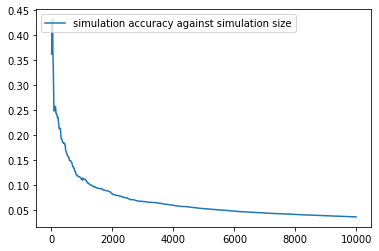

In [ ]:
# 1 emtiaze
sim_size = np.arange(10, 10000, 10)
sim_mean = np.array([np.mean(df['waiting_time'][:i]) for i in sim_size])
sim_std = np.array([np.std(df['waiting_time'][:i]) for i in sim_size])
sim_acc = (1.96 * sim_std) / (np.sqrt(sim_size) * sim_mean)
min_index = np.argmax(sim_acc < 0.05)
print('for n >= {} error is {:.3f} and less than 0.05'.format(sim_size[min_index], sim_acc[min_index]))
plt.figure()
plt.plot(sim_size, sim_acc, label='simulation accuracy against simulation size')
plt.legend(loc='upper left')
plt.show()
# plt.savefig('plots/5/accuracy.png')

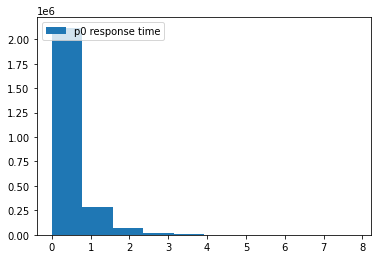

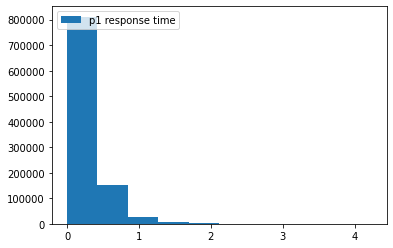

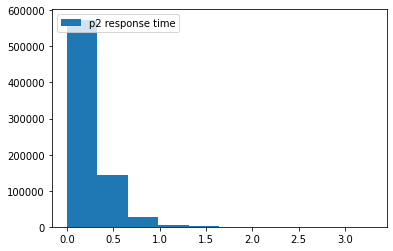

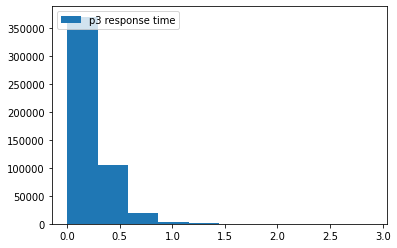

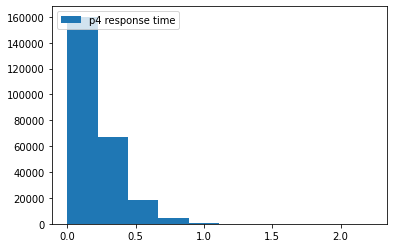

In [ ]:
arrival_time = df['arrival_time']
leave_time = arrival_time[:-1] + in_system_time

# 2 Frequency of response time
p0 = np.where(priority == 0)[0]
p1 = np.where(priority == 1)[0]
p2 = np.where(priority == 2)[0]
p3 = np.where(priority == 3)[0]
p4 = np.where(priority == 4)[0]

response_time = df['waiting_time'] + df['reception_time']
plt.figure()
plt.hist(response_time[p0], label='p0 response time')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.hist(response_time[p1], label='p1 response time')
plt.legend(loc='upper left')
plt.show()

response_time = df['waiting_time'] + df['reception_time']
plt.figure()
plt.hist(response_time[p2], label='p2 response time')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.hist(response_time[p3], label='p3 response time')
plt.legend(loc='upper left')
plt.show()

response_time = df['waiting_time'] + df['reception_time']
plt.figure()
plt.hist(response_time[p4], label='p4 response time')
plt.legend(loc='upper left')
plt.show()


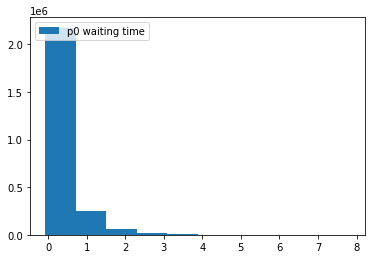

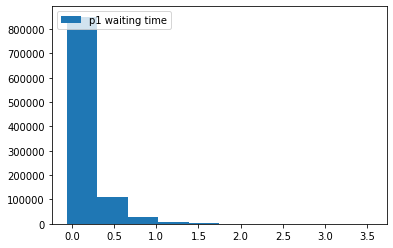

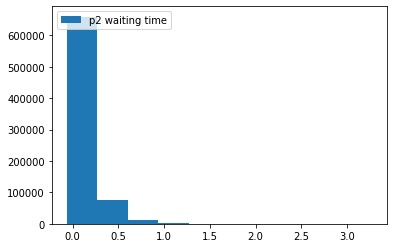

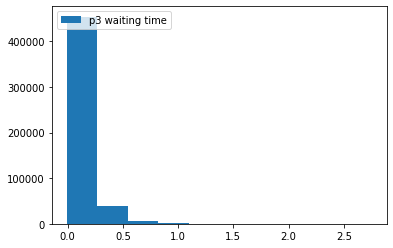

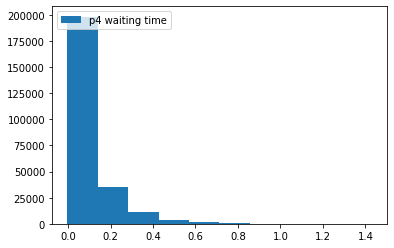

In [ ]:
#  Frequency of waiting time
plt.figure()
plt.hist(df['waiting_time'][p0], label='p0 waiting time')
plt.legend(loc='upper left')
plt.show()


plt.figure()
plt.hist(df['waiting_time'][p1], label='p1 waiting time')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.hist(df['waiting_time'][p2], label='p2 waiting time')
plt.legend(loc='upper left')
plt.show()


plt.figure()
plt.hist(df['waiting_time'][p3], label='p3 waiting time')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.hist(df['waiting_time'][p4], label='p4 waiting time')
plt.legend(loc='upper left')
plt.show()

